In [1]:
import pandas as pd

clinical_df = pd.read_csv('synthetic_clinical_dataset_dengue.csv')
sdoh_df = pd.read_csv('synthetic_sdoh_dataset.csv')


merged_df = clinical_df.merge(sdoh_df, on='dtcode11', how='left')
print("Merged dataset shape:", merged_df.shape)
print(merged_df.head())

Merged dataset shape: (50000, 22)
   Patient_ID  dtcode11  Age     Sex        BMI  Has_Hypertension  \
0        1001        65   60  Female  16.692014                 0   
1        1002        57   46  Female  28.648190                 0   
2        1003        63   77    Male  18.142187                 1   
3        1004        68   25    Male  19.783029                 0   
4        1005        65   44  Female  23.497274                 0   

   Has_High_Cholesterol  Family_History_Diabetes        Season  Has_Dengue  \
0                     0                        0  Post-Monsoon           0   
1                     0                        0  Post-Monsoon           0   
2                     1                        0         Other           0   
3                     0                        0       Monsoon           0   
4                     0                        0         Other           0   

   ... Pct_Scheduled_Caste  Avg_Household_Income  Pct_Illiterate  \
0  ...        

In [2]:
# Target variable
y = merged_df['Has_Dengue']

# Drop IDs and names for features
X = merged_df.drop(columns=['Has_Dengue', 'Patient_ID', 'dtname', 'dtcode11'])

# One-hot encode categorical features
X = pd.get_dummies(X, columns=['Sex','Season'], drop_first=True)

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [4]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(random_state=42, class_weight='balanced')
lgbm.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 6380, number of negative: 33620
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006607 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 489
[LightGBM] [Info] Number of data points in the train set: 40000, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


LGBMClassifier(class_weight='balanced', random_state=42)

Accuracy: 0.6854
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.64      0.77      8405
           1       0.33      0.91      0.48      1595

    accuracy                           0.69     10000
   macro avg       0.65      0.78      0.63     10000
weighted avg       0.87      0.69      0.73     10000



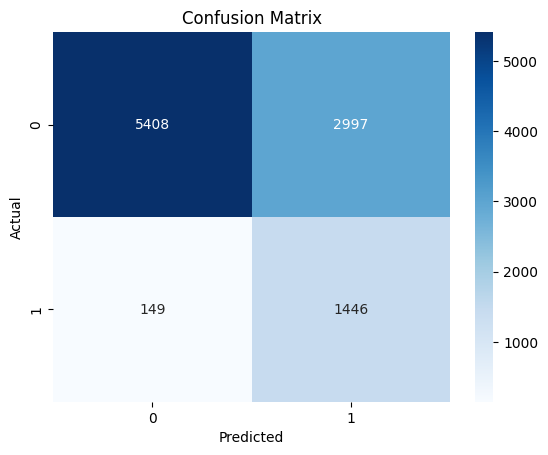

In [5]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = lgbm.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

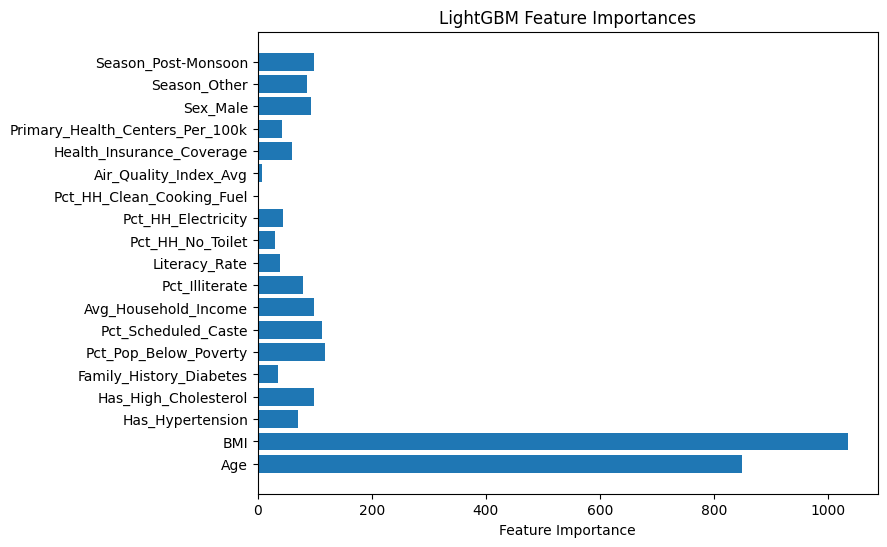

In [6]:
importances = lgbm.feature_importances_
feature_names = X.columns
plt.figure(figsize=(8,6))
plt.barh(feature_names, importances)
plt.xlabel("Feature Importance")
plt.title("LightGBM Feature Importances")
plt.show()

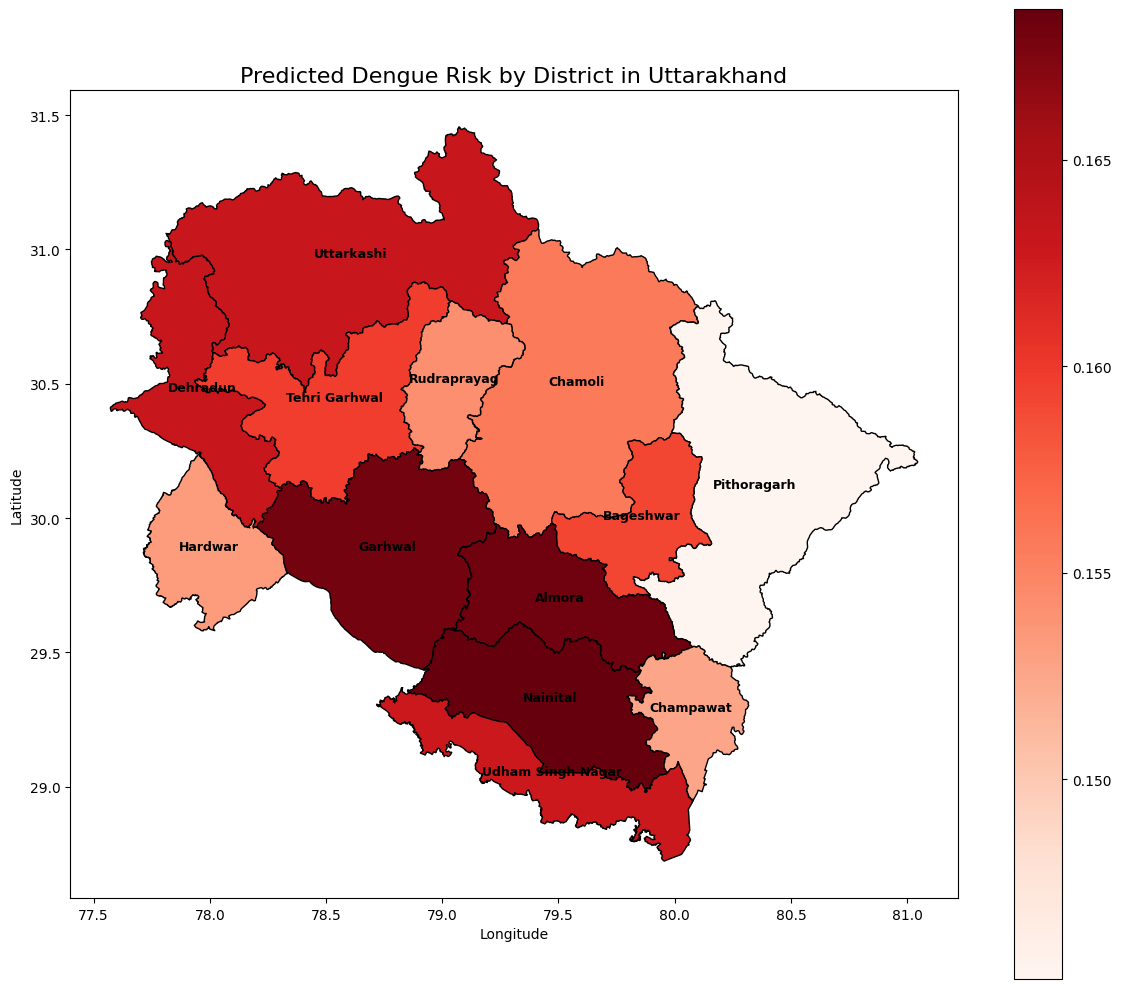

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Read the Uttarakhand districts GeoJSON
uttarakhand_map = gpd.read_file('UTTARAKHAND_DISTRICTS.geojson')

# Ensure dtcode11 is integer in both DataFrames
uttarakhand_map['dtcode11'] = uttarakhand_map['dtcode11'].astype(int)
district_risk = merged_df.groupby('dtcode11')['Has_Dengue'].mean().reset_index()

district_risk['dtcode11'] = district_risk['dtcode11'].astype(int)
district_risk.columns = ['dtcode11', 'Predicted_Risk']

# Merge with GeoJSON on dtcode11
map_with_risk = uttarakhand_map.merge(district_risk, on='dtcode11')

# Plot choropleth with improved labeling
fig, ax = plt.subplots(figsize=(12, 10))
map_with_risk.plot(column='Predicted_Risk', cmap='Reds', legend=True, ax=ax, edgecolor='black')

# Add district names as labels
for idx, row in map_with_risk.iterrows():
    if row['geometry'].centroid.is_empty:
        continue
    plt.annotate(
        text=row['dtname'].strip(),
        xy=(row['geometry'].centroid.x, row['geometry'].centroid.y),
        ha='center', fontsize=9, color='black', weight='bold'
    )

plt.title('Predicted Dengue Risk by District in Uttarakhand', fontsize=16)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.tight_layout()
plt.show()